In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.dists_kernels import AggrDist
from sktime.datasets import load_UCR_UEA_dataset
from sktime.classification.kernel_based import Arsenal, RocketClassifier, TimeSeriesSVC
from sktime.classification.interval_based import DrCIF, CanonicalIntervalForest, RandomIntervalSpectralEnsemble

from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report, precision_recall_fscore_support 

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train, y_train = load_UCR_UEA_dataset(name="PLAID",
                                        split='train', 
                                        return_type=None,
                                        extract_path="./data")
X_test, y_test = load_UCR_UEA_dataset(name="PLAID",
                                      split='test', 
                                      return_type=None,
                                      extract_path='./data')

In [3]:
X_train.head()

,dim_0
0,0 0.173390 1 0.130450 2 0.13...
1,0 0.002441 1 -0.003128 2 0.00086...
2,0 -0.003967 1 0.002576 2 -0.00074...
3,0 -0.000005 1 0.000005 2 0.00001...
4,0 0.000011 1 0.000005 2 -0.00000...


In [4]:
max_length = 600

def pad_series(x):
    if len(x) < max_length:
        return np.pad(x, (0, max_length - len(x)), 'constant', constant_values=(0,))
    return x.values[:max_length]

X_train_padded = X_train.applymap(pad_series)
X_test_padded = X_test.applymap(pad_series)

X_train_arrays = [np.stack(row) for _, row in X_train_padded.iterrows()]
X_test_arrays = [np.stack(row) for _, row in X_test_padded.iterrows()]

X_train = np.stack(X_train_arrays, axis=0)
X_test = np.stack(X_test_arrays, axis=0)

print(X_train.shape)
print(X_test.shape)

(537, 1, 600)
(537, 1, 600)


In [5]:
len(y_train)

537

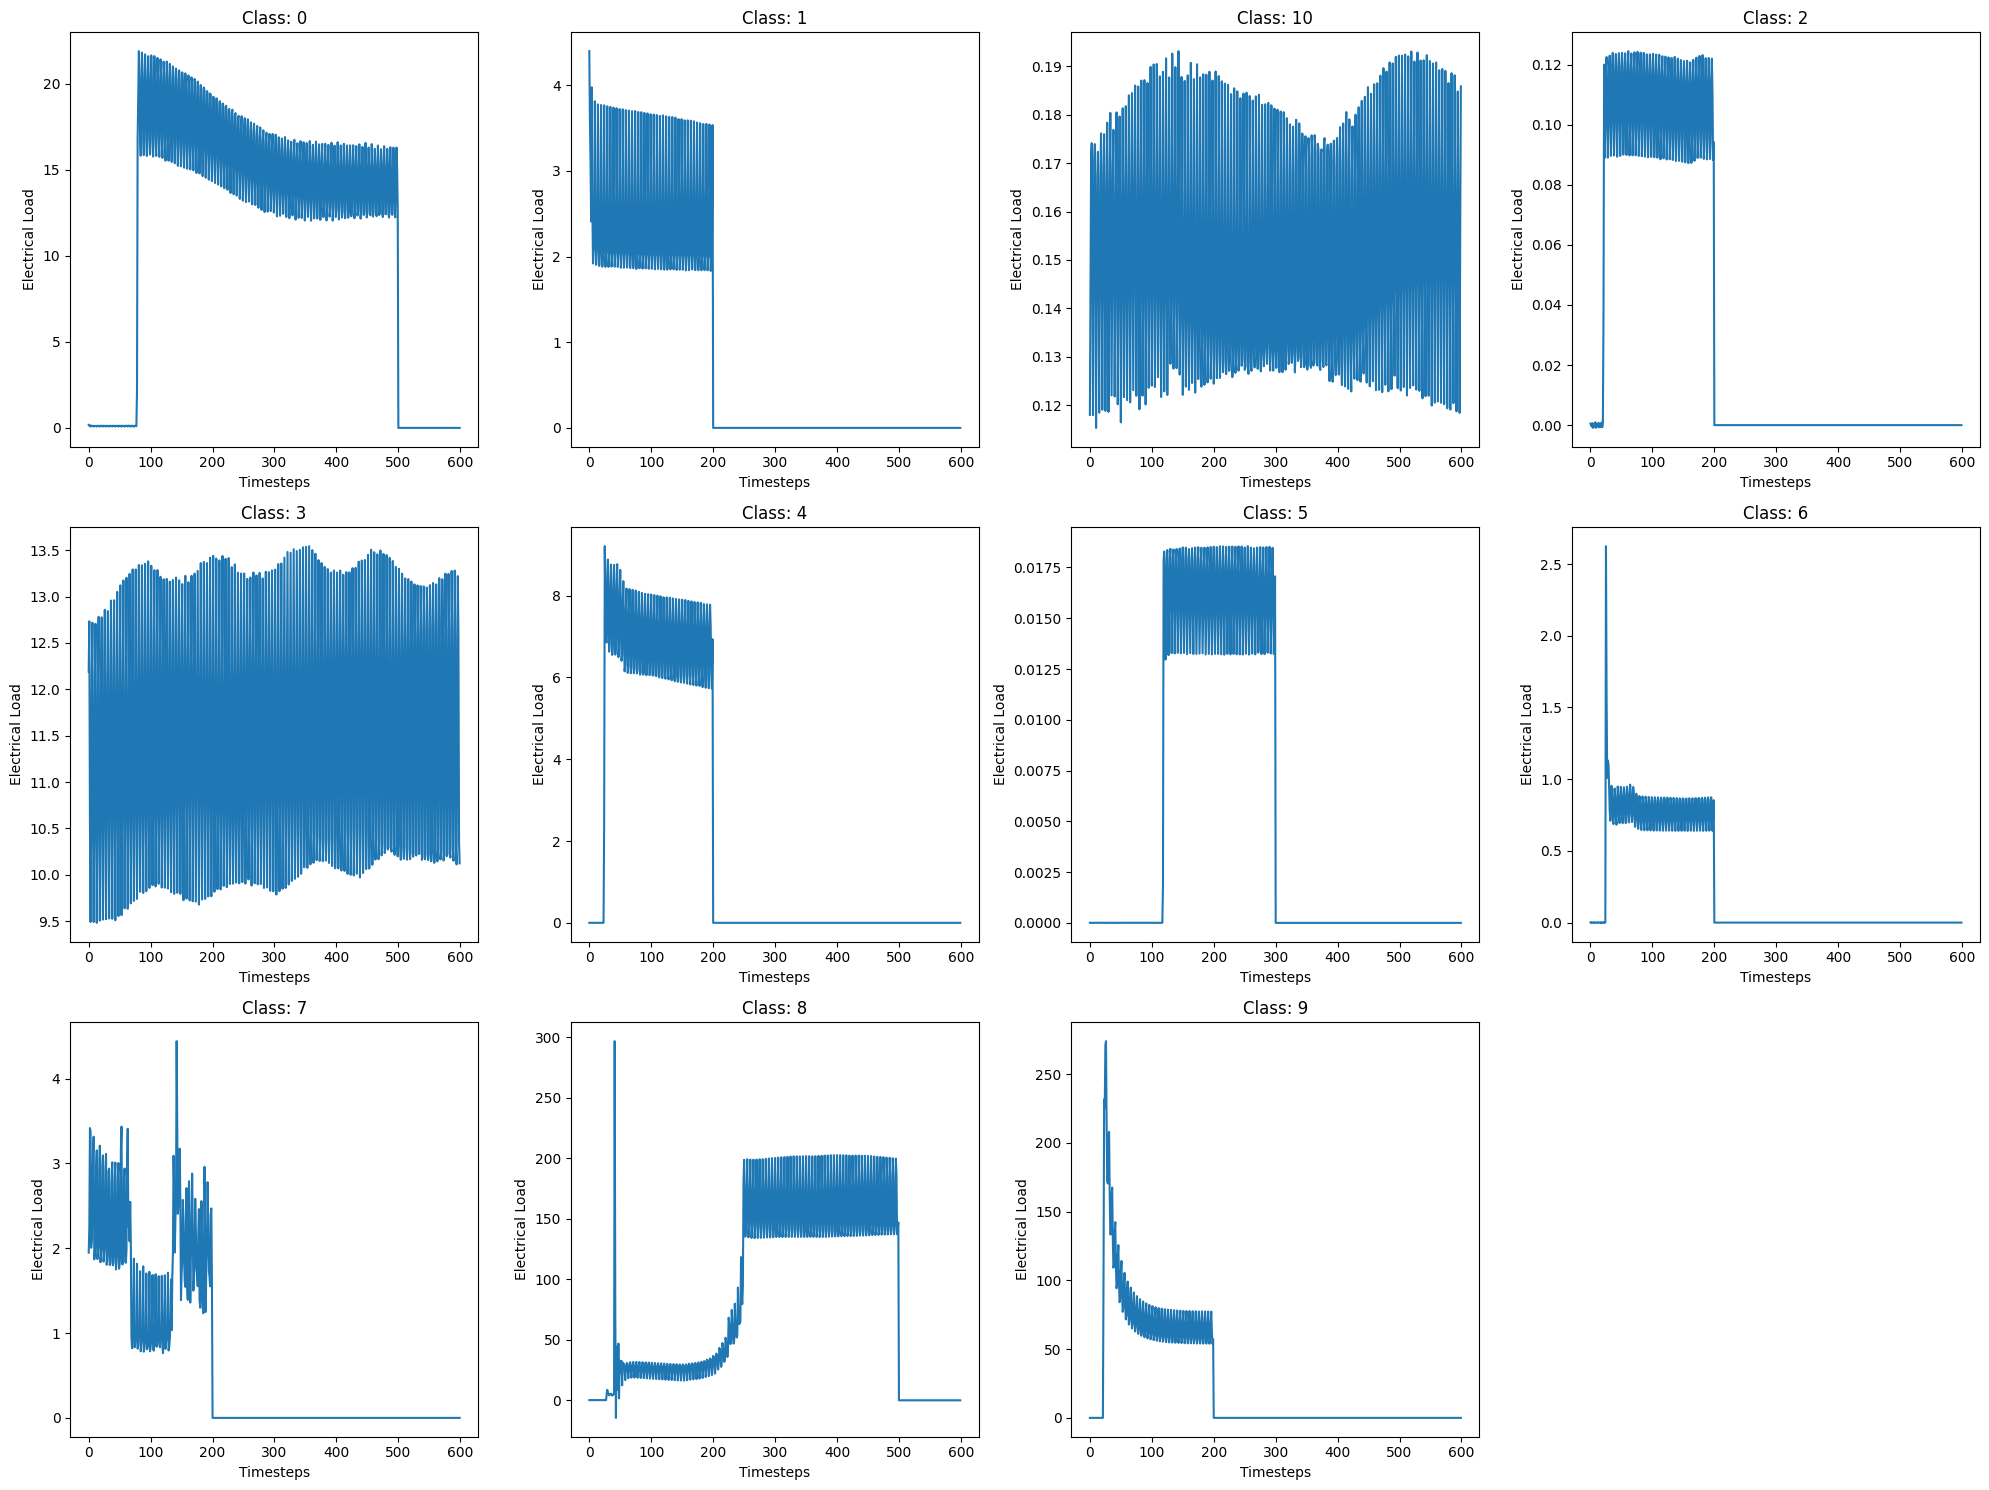

In [6]:
y_train_plotting = pd.Series(y_train)

fig, axes = plt.subplots(3, 4, figsize=(20,15))
axes = axes.flatten()

for i, label in enumerate(sorted(y_train_plotting.unique())):
    idx = y_train_plotting[y_train_plotting == label].index[0]

    data = X_train[idx, 0, :]

    axes[i].plot(data)
    axes[i].set_title(f"Class: {label}")
    axes[i].set_xlabel('Timesteps')
    axes[i].set_ylabel('Electrical Load')

fig.delaxes(axes[-1])
plt.tight_layout()

## RISE

In [7]:
%%time

rise = RandomIntervalSpectralEnsemble(
    n_estimators=200,
    min_interval=10,
    acf_lag=100,
    acf_min_values=100,
    n_jobs=-1,
    random_state=42
)

rise.fit(X_train, y_train)
y_pred = rise.predict(X_test)

clf_report = classification_report(y_test, y_pred)

_, _, rise_fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(clf_report)

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        33
           1       0.98      0.99      0.98        87
          10       1.00      0.54      0.70        13
           2       0.80      0.95      0.87        58
           3       1.00      0.37      0.54        19
           4       0.84      0.96      0.90        78
           5       1.00      0.82      0.90        17
           6       0.86      0.89      0.88        57
           7       0.96      0.99      0.97        86
           8       0.91      0.99      0.95        70
           9       1.00      0.95      0.97        19

    accuracy                           0.91       537
   macro avg       0.94      0.83      0.86       537
weighted avg       0.92      0.91      0.90       537

CPU times: total: 891 ms
Wall time: 10.5 s


## CIF

In [8]:
%%time

cif = CanonicalIntervalForest(
    n_estimators=50,
    n_intervals=2,        
    att_subsample_size=8,
    min_interval=3,
    max_interval=100,   
    n_jobs=-1,
    random_state=42
)

cif.fit(X_train, y_train)
y_pred = cif.predict(X_test)

clf_report = classification_report(y_test, y_pred)

_, _, cif_fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(clf_report)

              precision    recall  f1-score   support

           0       1.00      0.39      0.57        33
           1       0.67      0.91      0.77        87
          10       1.00      0.31      0.47        13
           2       0.54      0.57      0.55        58
           3       1.00      0.32      0.48        19
           4       0.66      0.83      0.73        78
           5       0.71      0.29      0.42        17
           6       0.67      0.63      0.65        57
           7       0.81      0.84      0.82        86
           8       0.90      0.90      0.90        70
           9       0.94      0.79      0.86        19

    accuracy                           0.73       537
   macro avg       0.81      0.62      0.66       537
weighted avg       0.76      0.73      0.72       537

CPU times: total: 22.5 s
Wall time: 33.6 s


## DrCIF

In [9]:
%%time

drcif = DrCIF(
    n_estimators=5,
    n_intervals=2,        
    att_subsample_size=8, 
    min_interval=3,
    max_interval=100,    
    base_estimator="CIT",
    n_jobs=-1,
    random_state=42
)

drcif.fit(X_train, y_train)
y_pred = drcif.predict(X_test)

clf_report = classification_report(y_test, y_pred)

_, _, drcif_fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(clf_report)

              precision    recall  f1-score   support

           0       0.44      0.36      0.40        33
           1       0.80      0.83      0.81        87
          10       0.44      0.31      0.36        13
           2       0.47      0.60      0.53        58
           3       0.42      0.26      0.32        19
           4       0.75      0.56      0.64        78
           5       0.67      0.24      0.35        17
           6       0.61      0.82      0.70        57
           7       0.72      0.78      0.75        86
           8       0.76      0.77      0.77        70
           9       0.83      0.79      0.81        19

    accuracy                           0.67       537
   macro avg       0.63      0.58      0.59       537
weighted avg       0.67      0.67      0.66       537

CPU times: total: 422 ms
Wall time: 5.24 s


## SVC

In [10]:
%%time

kernel = AggrDist(RBF())

svc = TimeSeriesSVC(kernel=kernel,
                    random_state=42)

svc.fit(X_train[:, :, :200], y_train)
y_pred = svc.predict(X_test[:, :, :200])

clf_report = classification_report(y_test, y_pred)

_, _, svc_fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(clf_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.23      1.00      0.37        87
          10       0.00      0.00      0.00        13
           2       0.33      0.09      0.14        58
           3       0.00      0.00      0.00        19
           4       0.40      0.46      0.43        78
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        57
           7       0.43      0.22      0.29        86
           8       0.25      0.01      0.03        70
           9       0.00      0.00      0.00        19

    accuracy                           0.28       537
   macro avg       0.15      0.16      0.11       537
weighted avg       0.23      0.28      0.19       537

CPU times: total: 4min 45s
Wall time: 4min 45s


## Rocket

In [11]:
%%time

clf = RocketClassifier(num_kernels=1000, 
                       n_jobs=-1,
                       random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

clf_report = classification_report(y_test, y_pred)

_, _, rocket_fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(clf_report)

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        33
           1       1.00      0.99      0.99        87
          10       0.92      0.85      0.88        13
           2       0.73      0.64      0.68        58
           3       0.89      0.42      0.57        19
           4       0.70      0.88      0.78        78
           5       0.88      0.41      0.56        17
           6       0.89      0.96      0.92        57
           7       0.87      1.00      0.93        86
           8       1.00      0.99      0.99        70
           9       1.00      1.00      1.00        19

    accuracy                           0.88       537
   macro avg       0.90      0.80      0.83       537
weighted avg       0.88      0.88      0.87       537

CPU times: total: 8.27 s
Wall time: 10 s


## Arsenal

In [12]:
%%time

clf = Arsenal(num_kernels=500,       
              n_estimators=10,         
              time_limit_in_minutes=2,
              n_jobs=-1,
              random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

clf_report = classification_report(y_test, y_pred)

_, _, arsenal_fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(clf_report)

              precision    recall  f1-score   support

           0       0.93      0.76      0.83        33
           1       1.00      0.99      0.99        87
          10       1.00      0.85      0.92        13
           2       0.76      0.67      0.72        58
           3       0.89      0.42      0.57        19
           4       0.74      0.90      0.81        78
           5       0.80      0.47      0.59        17
           6       0.90      0.96      0.93        57
           7       0.87      1.00      0.93        86
           8       1.00      1.00      1.00        70
           9       1.00      1.00      1.00        19

    accuracy                           0.89       537
   macro avg       0.90      0.82      0.85       537
weighted avg       0.89      0.89      0.88       537

CPU times: total: 17.2 s
Wall time: 52.7 s


## Evaluation

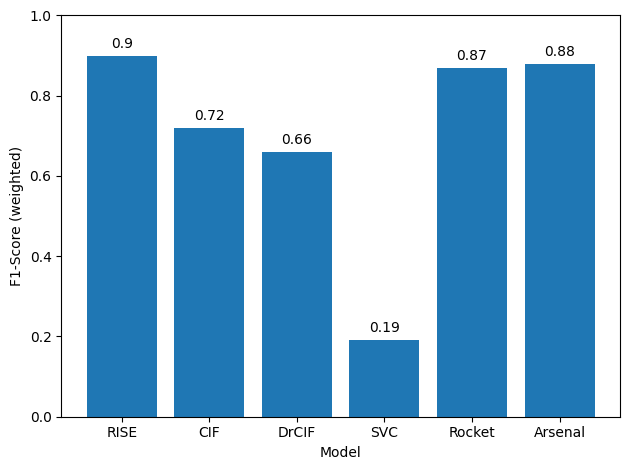

In [15]:
x = ['RISE', 'CIF', 'DrCIF', 'SVC', 'Rocket', 'Arsenal']
y = [rise_fscore, cif_fscore, drcif_fscore, svc_fscore, rocket_fscore, arsenal_fscore]
y = np.around(y,2).tolist()

fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_xlabel('Model')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1)

for i, v in enumerate(y):
    ax.text(x=i, y=v+0.02, s=str(v), ha='center')

plt.tight_layout()